Cilj ovog projekta je analizirati skup podataka o šutevima iz NBA-a i predvidjeti njihovu uspješnost koristeći različite algoritme strojnog učenja. Projekt je inspiriran radom "Predicting NBA Shots" autora Bretta Meehana.

#Učitavanje biblioteka i podataka

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


In [285]:
data = pd.read_csv("shot_logs.csv")
data.columns = [
    'Game ID', 'Matchup', 'Location', 'Win indicator', 'Final margin',
    'Shot number', 'Period', 'Game clock', 'Shot clock', 'Dribbles',
    'Touch time', 'Shot distance', 'Points type', 'Shot result',
    'Closest defender', 'Closest defender ID', 'Closest defender distance',
    'Field goal made', 'Points scored', 'Player name', 'Player ID'
]
data.head()

,Game ID,Matchup,Location,Win indicator,Final margin,Shot number,Period,Game clock,Shot clock,Dribbles,...,Shot distance,Points type,Shot result,Closest defender,Closest defender ID,Closest defender distance,Field goal made,Points scored,Player name,Player ID
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


#Informacije o dataset-u

Pregled dimenzija i tipova podataka.

In [286]:
data.shape

(128069, 21)

In [287]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Game ID                    128069 non-null  int64  
 1   Matchup                    128069 non-null  object 
 2   Location                   128069 non-null  object 
 3   Win indicator              128069 non-null  object 
 4   Final margin               128069 non-null  int64  
 5   Shot number                128069 non-null  int64  
 6   Period                     128069 non-null  int64  
 7   Game clock                 128069 non-null  object 
 8   Shot clock                 122502 non-null  float64
 9   Dribbles                   128069 non-null  int64  
 10  Touch time                 128069 non-null  float64
 11  Shot distance              128069 non-null  float64
 12  Points type                128069 non-null  int64  
 13  Shot result                12

 Prikaz deskriptivne statistike koja obuhvaća raspon, medijan i prosjek za numeričke značajke.

In [288]:
data.describe()

,Game ID,Final margin,Shot number,Period,Shot clock,Dribbles,Touch time,Shot distance,Points type,Closest defender ID,Closest defender distance,Field goal made,Points scored,Player ID
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


 Prikaz broja nedostajućih vrijednosti po stupcima.

In [289]:
data.isnull().sum()

,0
Game ID,0
Matchup,0
Location,0
Win indicator,0
Final margin,0
Shot number,0
Period,0
Game clock,0
Shot clock,5567
Dribbles,0


Vizualizacija udaljenosti šuta.

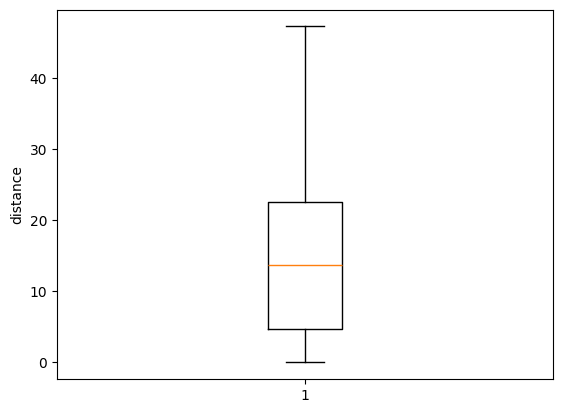

In [290]:
plt.boxplot(data['Shot distance'])
plt.ylabel('distance')
plt.show()

Vizualizacija udaljenosti najbližeg obrambenog igrača.

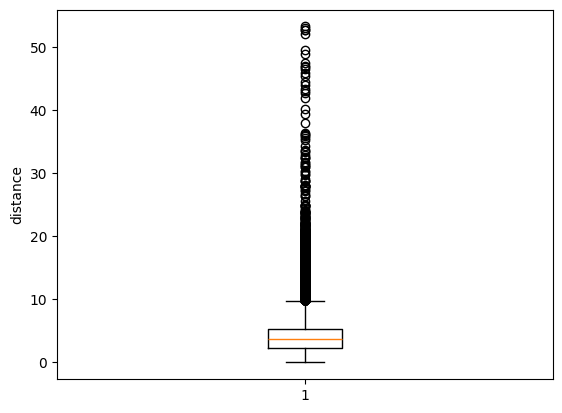

In [291]:
plt.boxplot(data['Closest defender distance'])
plt.ylabel('distance')
plt.show()

Vizualizacija vremena šuta.

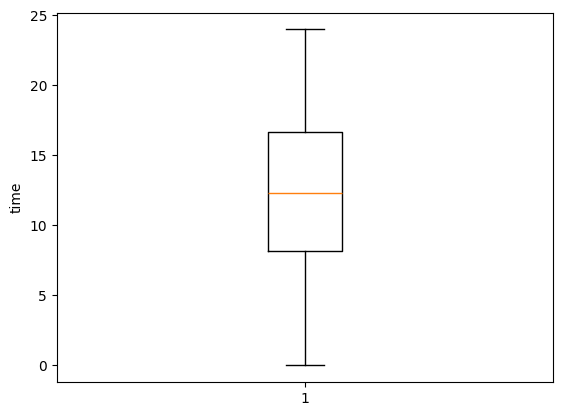

In [292]:
plt.boxplot(data['Shot clock'].dropna())
plt.ylabel('time')
plt.show()

Provjera monotonosti atributa.

In [293]:
data.nunique()

,0
Game ID,904
Matchup,1808
Location,2
Win indicator,2
Final margin,88
Shot number,38
Period,7
Game clock,719
Shot clock,241
Dribbles,33


#Vizualizacija podataka

Distribucija vremena izvođenja šuta.

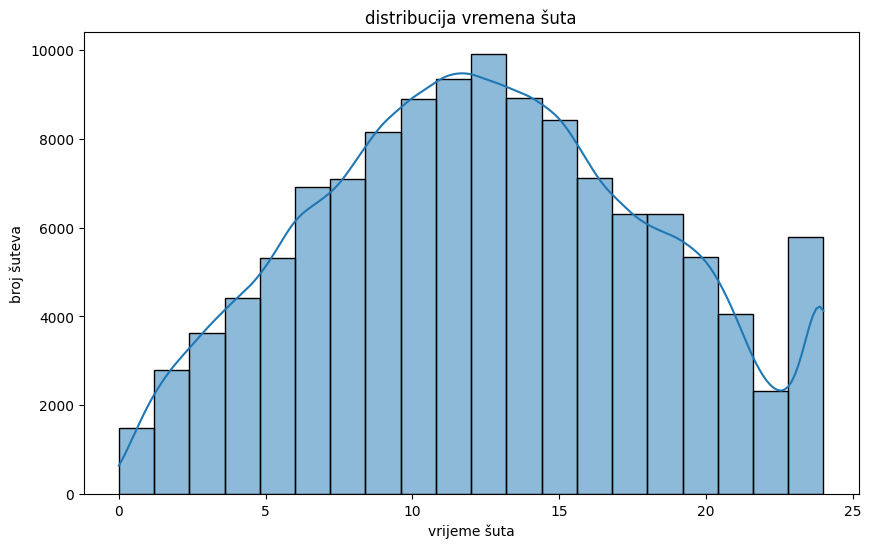

In [294]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Shot clock'], kde=True, bins=20)
plt.title("distribucija vremena šuta")
plt.xlabel("vrijeme šuta")
plt.ylabel("broj šuteva")
plt.show()

Uspješnost šuteva u domaćim i gortujućim utakmicama.

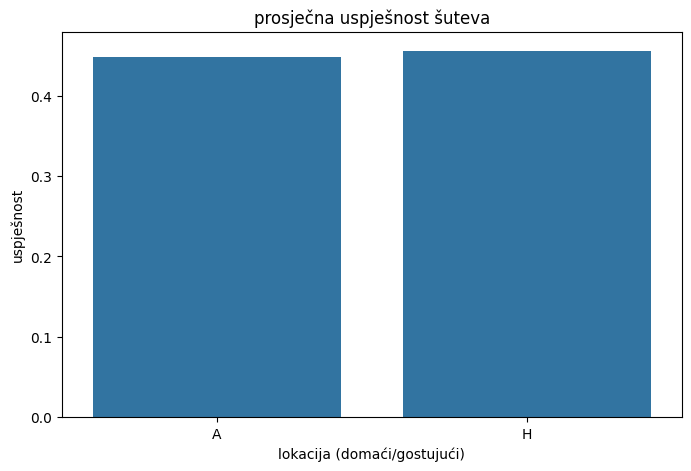

In [295]:
location = data.groupby('Location')['Field goal made'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='Location', y='Field goal made', data=location)
plt.title("prosječna uspješnost šuteva")
plt.xlabel("lokacija (domaći/gostujući)")
plt.ylabel("uspješnost")
plt.show()


Prikaz udaljenosti šuteva od koša.

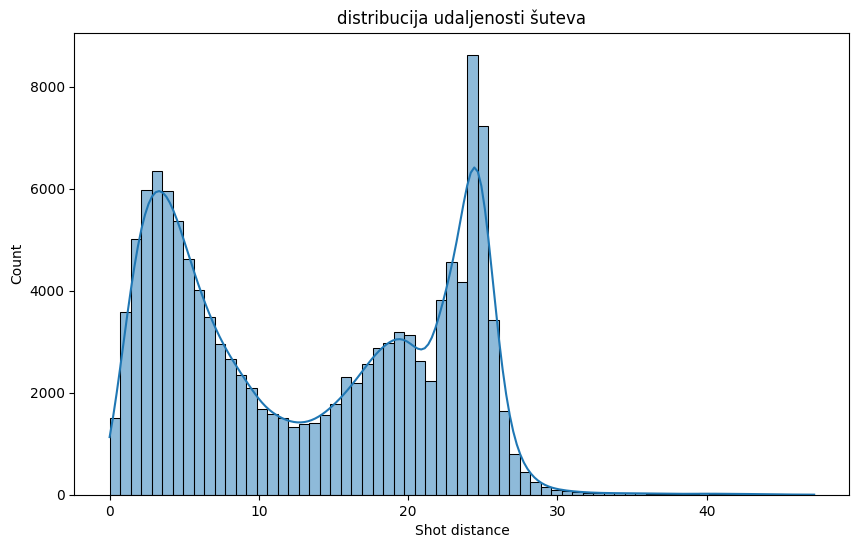

In [296]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Shot distance'], kde=True)
plt.title("distribucija udaljenosti šuteva")
plt.show()

Uspješnost šuteva u odnosu na udaljenost.

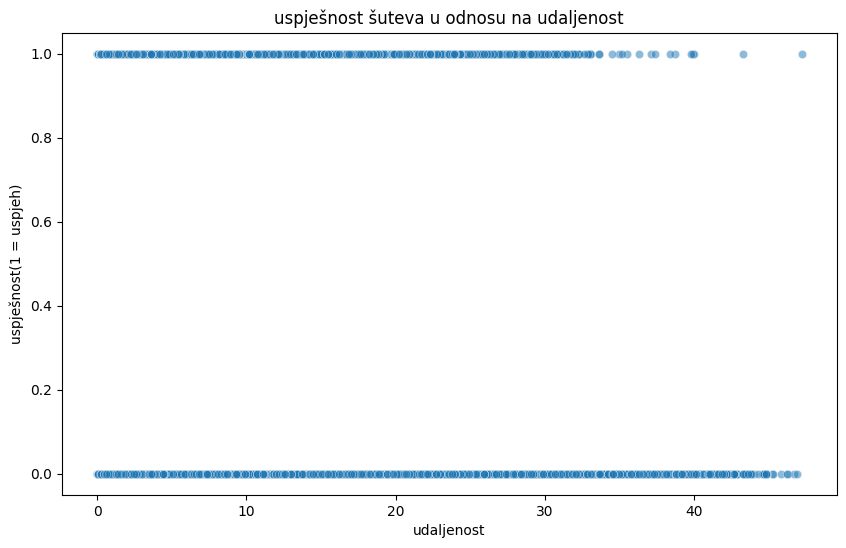

In [297]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Shot distance'], y=data['Field goal made'], alpha=0.5)
plt.title("uspješnost šuteva u odnosu na udaljenost")
plt.xlabel("udaljenost")
plt.ylabel("uspješnost(1 = uspjeh)")
plt.show()

Uspješnost šuteva u različitim periodima igre.

<ipython-input-298-1d76f2bd9044>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Period', y='Field goal made', data=period, palette="viridis")


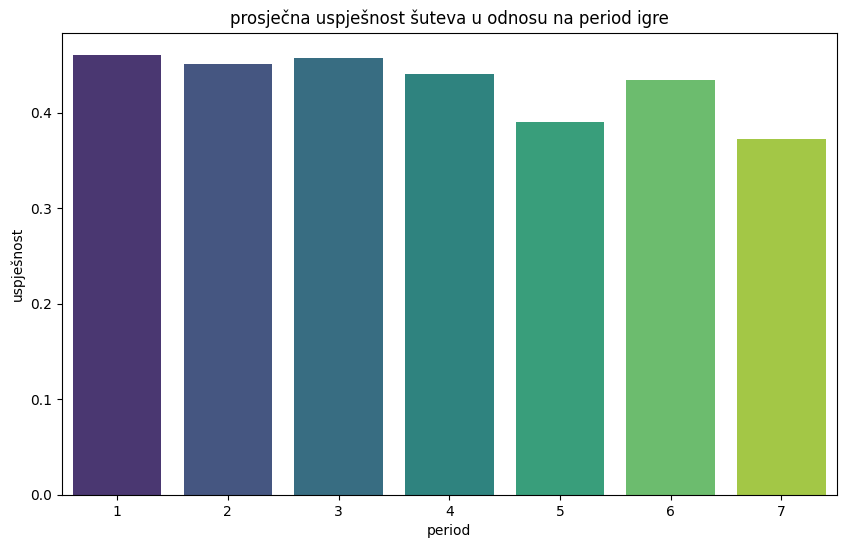

In [298]:
period = data.groupby('Period')['Field goal made'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Period', y='Field goal made', data=period, palette="viridis")
plt.title("prosječna uspješnost šuteva u odnosu na period igre")
plt.xlabel("period")
plt.ylabel("uspješnost")
plt.show()


#Istraživanje podataka

Analiza razlike u distribuciji uspješnih i neuspješnig šuteva.

broj uspješnih šuteva: 57905
broj neuspješnih šuteva: 70164


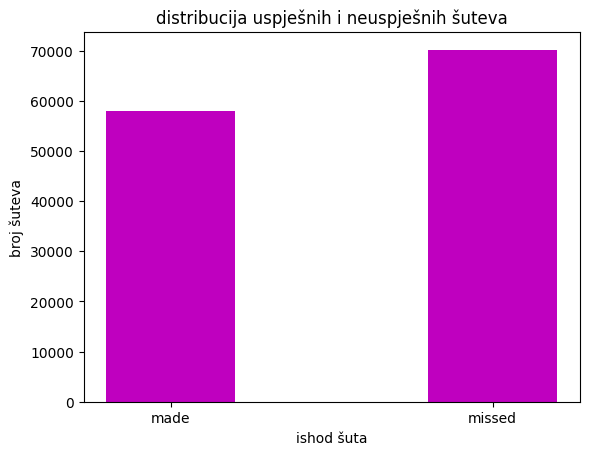

In [299]:
made = data['Shot result'].value_counts()['made']
missed = data['Shot result'].value_counts()['missed']

print("broj uspješnih šuteva:", made)
print("broj neuspješnih šuteva:", missed)

categories = ['made', 'missed']
values = [made, missed]

plt.bar(categories, values, color='m', width=0.4)
plt.xlabel("ishod šuta")
plt.ylabel("broj šuteva")
plt.title("distribucija uspješnih i neuspješnih šuteva")
plt.show()


Prikaz korelacije među numeričkim značajkama.

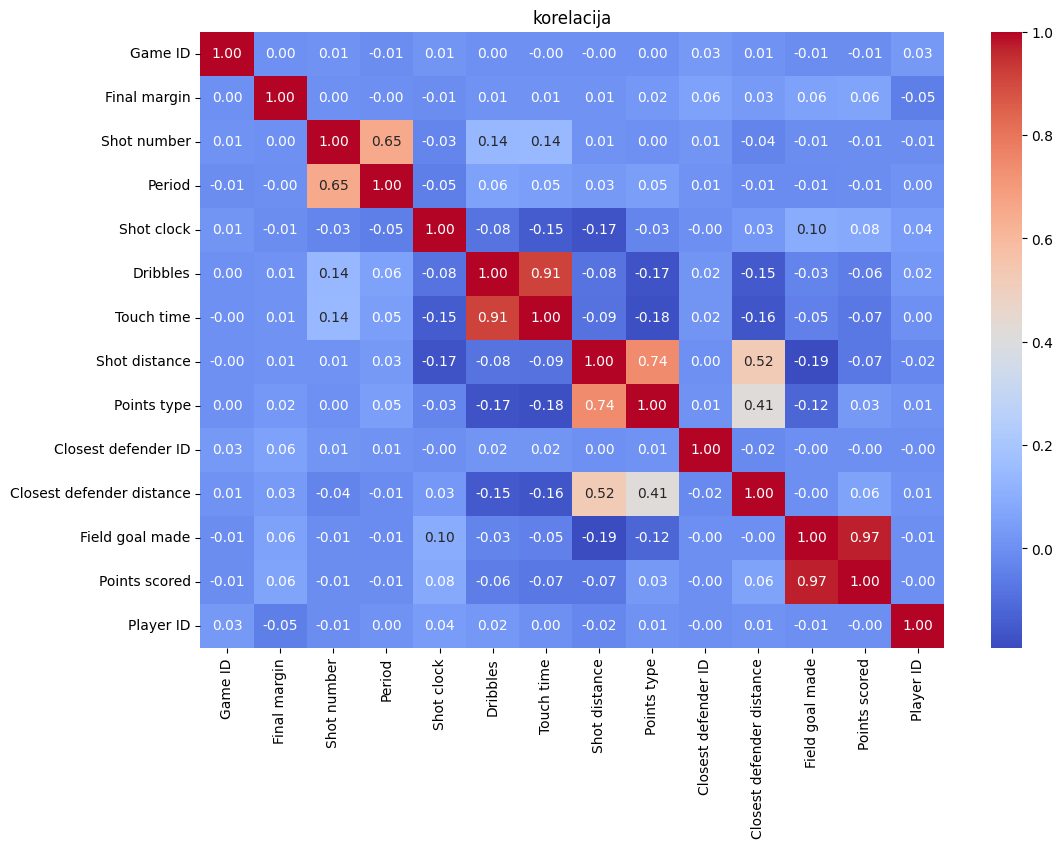

In [300]:
ndata = data.select_dtypes(include=['float64', 'int64'])
corr = ndata.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('korelacija')
plt.show()

#Priprema podataka za algoritme strojnog učenja.

 Uklanjanje nepotrebnih značajki, provjera i uklanjanje nedostajućih vrijednosti, normalizacija numeričkih značajki, pretvorba string varijabli u kategoričke te mapiranje ciljne varijable.

In [301]:
data = data.drop(['Game ID', 'Matchup', 'Closest defender', 'Player name', 'Closest defender ID', 'Player ID'], axis=1)


'Game ID', 'Matchup', 'Closest defender', 'Player name', 'Closest defender ID' i 'Player ID' su podatci koji direktno ne utječu na uspješnost šuta te ih zbog toga uklanjamo.

In [302]:

data['Shot result'] = data['Shot result'].map({'made': 1, 'missed': 0})
data.head()

,Location,Win indicator,Final margin,Shot number,Period,Game clock,Shot clock,Dribbles,Touch time,Shot distance,Points type,Shot result,Closest defender distance,Field goal made,Points scored
0,A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,1,1.3,1,2
1,A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,0,6.1,0,0
2,A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,0,0.9,0,0
3,A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,0,3.4,0,0
4,A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,0,1.1,0,0


In [303]:
from sklearn.preprocessing import StandardScaler

data['Shot clock'] = data['Shot clock'].fillna(data['Shot clock'].mean())
def toseconds(time):
    if isinstance(time, str):
        try:
            minutes, seconds = map(int, time.split(':'))
            return minutes * 60 + seconds
        except ValueError:
            return None
    return time

data['Game clock'] = data['Game clock'].apply(toseconds)
data['Game clock'] = data['Game clock'].fillna(data['Game clock'].median())

numericcol = ['Shot distance', 'Closest defender distance', 'Shot clock', 'Touch time', 'Dribbles', 'Final margin']
scaler = StandardScaler()
data[numericcol] = scaler.fit_transform(data[numericcol])

catcol = ['Location', 'Win indicator', 'Points type']
for col in catcol:
    data[col] = data[col].astype('category')

data.head()

,Location,Win indicator,Final margin,Shot number,Period,Game clock,Shot clock,Dribbles,Touch time,Shot distance,Points type,Shot result,Closest defender distance,Field goal made,Points scored
0,A,W,1.797845,1,1,69,-2.933234e-01,-0.006715,-0.284492,-0.660541,2,1,-1.024154,1,2
1,A,W,1.797845,2,1,14,-1.606174e+00,-0.581800,-0.645898,1.645698,3,0,0.717225,0,0
2,A,W,1.797845,3,1,0,3.151475e-16,0.280827,-0.021652,-0.390542,2,0,-1.169269,0,0
3,A,W,1.797845,4,2,707,-3.820295e-01,-0.006715,-0.284492,0.408204,2,0,-0.262301,0,0
4,A,W,1.797845,5,2,634,-2.755822e-01,-0.006715,-0.021652,-1.110539,2,0,-1.096712,0,0


Podjelom podataka na ulazne značajke i ciljne vrijednosti te podjelom na skupove za treniranje i testiranje omogućujemo primjenu algoritama strojnog učenja.

In [312]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Shot result'])
y = data['Shot result']


Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.05, random_state=42)

print("dimenzije Xtrain:", Xtrain.shape)
print("dimenzije ytrain:", ytrain.shape)


dimenzije Xtrain: (121665, 14)
dimenzije ytrain: (121665,)


#Algoritmi strojnog učenja

Koristeći više algoritama strojnog učenja, usporediti ćemo performanse te odabrati najprikladniji model za odabrane podatke.

**Logistička regresija** je model koji se najčešće koristi za binarne klasifikacije.
Kategorijske varijable pretvorene su u numerički format kako bi bile kompatibilne s logističkom regresijom.



In [305]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Xtrain2 = Xtrain.copy()
Xtest2 = Xtest.copy()

catcol = ['Location', 'Win indicator', 'Points type']
Xtrain2 = pd.get_dummies(Xtrain2, columns=catcol)
Xtest2 = pd.get_dummies(Xtest2, columns=catcol)


logreg = LogisticRegression(max_iter=1000)
logreg.fit(Xtrain2, ytrain)
ypred = logreg.predict(Xtest2)
accuracy = accuracy_score(ytest, ypred)
print(f"Točnost modela: {accuracy * 100:.2f}%")


Točnost modela: 100.00%


**SVM** je algoritam strojnog učenja koji se koristi za klasifikaciju i regresiju, a djeluje tako da pronalazi ravninu koji razdvaja klase podataka u prostoru značajki.

In [306]:
from sklearn.svm import SVC

scaler = StandardScaler()
Xtrain2s = scaler.fit_transform(Xtrain2)
Xtest2s = scaler.transform(Xtest2)

model = SVC(kernel='linear')
model.fit(Xtrain2s, ytrain)

ypred = model.predict(Xtest2s)
accuracy = accuracy_score(ytest, ypred)
print(f"točnost modela: {accuracy * 100}%")


točnost modela: 100.0%


**Naive Bayes** je algoritam temeljen na Bayesovom teoremu.

In [307]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(Xtrain2, ytrain)

ypred = model.predict(Xtest2)
accuracy = accuracy_score(ytest, ypred)
print(f"točnost modela: {accuracy * 100:.2f}%")


točnost modela: 100.00%


**Neuronske mreže** koriste slojeve međusobno povezanih "neurona" kako bi modelirale složene odnose između ulaznih značajki i ciljeva.

In [308]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=1000, random_state=42)
model.fit(Xtrain2, ytrain)

ypred = model.predict(Xtest2)
accuracy = accuracy_score(ytest, ypred)
print(f"točnost neuronske mreže: {accuracy * 100:.2f}%")


točnost neuronske mreže: 100.00%


**Random Forest** je algoritam koji koristi više stabala odlučivanja kako bi smanjio varijancu i poboljšao točnost

In [309]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(Xtrain2, ytrain)

ypred = model.predict(Xtest2)
accuracy = accuracy_score(ytest, ypred)
print(f"točnost modela: {accuracy * 100:.2f}%")


točnost modela: 100.00%


**XGBoost** je biblioteka strojnog učenja napravljena za probleme klasifikacije i regresije. Algoritam gradientnog boostinga stvara prediktivan modela najčešće kombiniranjem stabala odluke.

In [310]:
model = XGBClassifier(enable_categorical = True)
model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)

accuracy = accuracy_score(ytest, ypred)
print(f"točnost modela: {accuracy * 100}%")


točnost modela: 100.0%


**KNN** je algoritam koji klasificira primjere na temelju sličnosti s najbližim susjedom.

In [311]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(Xtrain2, ytrain)

ypred = model.predict(Xtest2)
accuracy = accuracy_score(ytest, ypred)
print(f"točnost modela: {accuracy * 100}%")


točnost modela: 99.35977514053717%


#Zaključak

Rezultati analize pokazuju iznimno visoku točnost modela, pri čemu su logistička regresija, SVM, neuronske mreže, Random Forest i XGBoost postigli točnost od 100%, dok je KNN ostvario nešto nižu točnost od 99.25%. KNN je izabran kao još jedan dodatni model za evaluaciju rezultata. Podjela podataka provedena je u omjeru 95% za treniranje i 5% za testiranje, čime se osigurala konzistentnost s metodologijom primjera rada.
Postignuti rezultati ističu potencijal strojnog učenja u predikciji uspješnosti šuteva u košarci, uz visoku razinu točnosti i efikasnosti korištenih algoritama. Usporedbom s rezultatima službenog rada, koji su varirali između 54% i 68%, može se zaključiti kako razlike proizlaze iz različitih metodoloških pristupa pripremi i obradi podataka te evaluaciji modela.